In [ ]:
!pip install d3rlpy
!apt-get install -y xvfb ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay pygame moviepy > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 57.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.8 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827621 sha256=5682ececece2c0170bb3a5c9c560c4b1606f194ff8cd90e760490d11bbc73a56
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does

# Библиотека d3rlpy (An offline deep reinforcement learning library)

https://github.com/takuseno/d3rlpy/tree/v2.3.0

Библиотека реализующая в себе алгоритмы автономного и глубокого обучения с подкреплением.

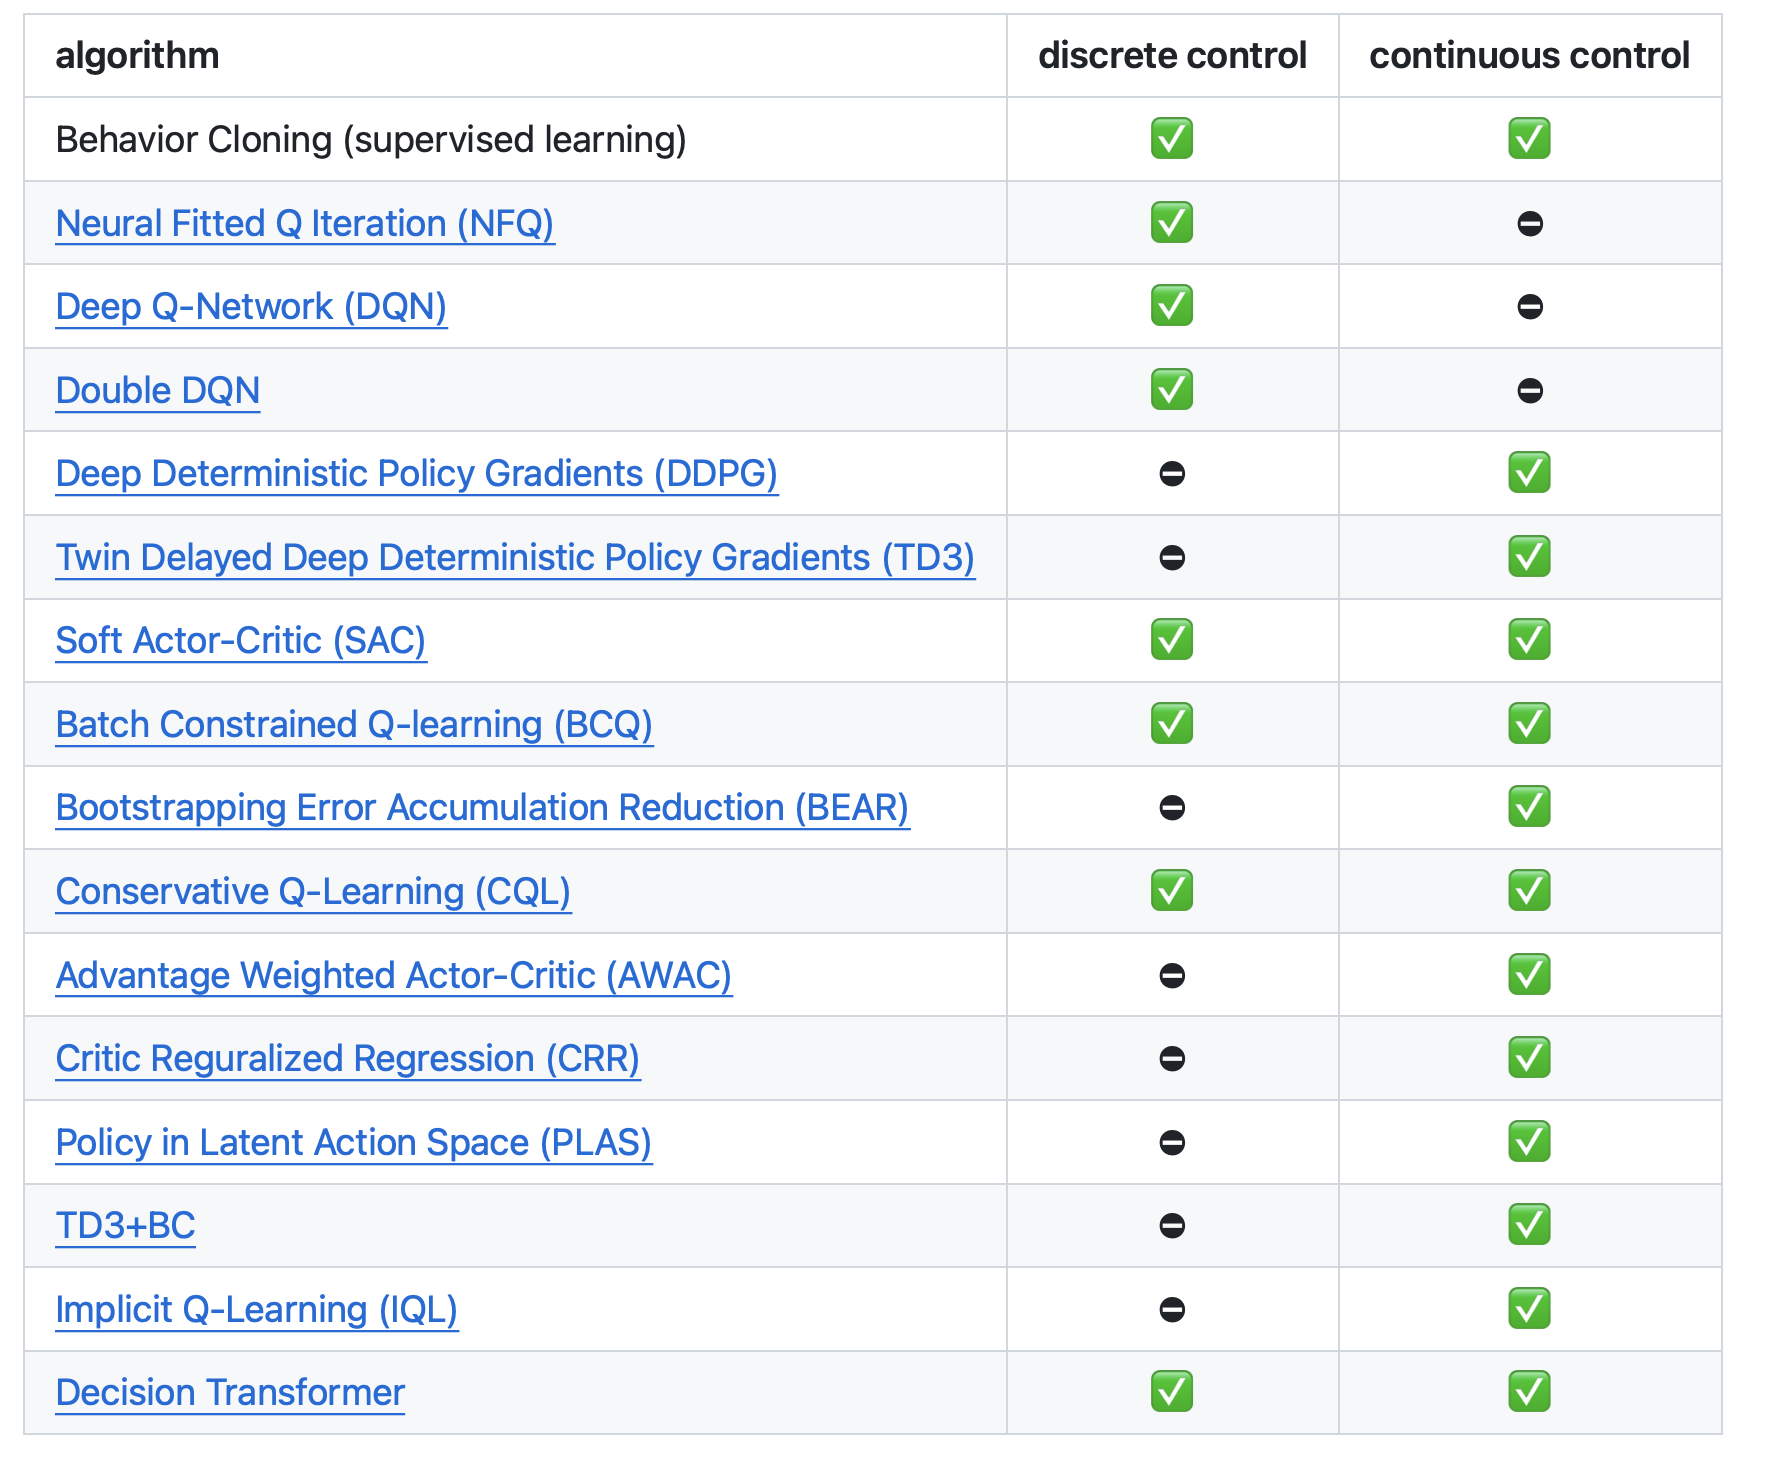

План:

1) Запуск алгоритмов автономного обучения с подкреплением в d3rlpy

2) Эксперименты с данными для РЛ агента

3) Offline RL vs BC

In [ ]:
import matplotlib.pyplot as plt


def plot_metrics(statistics, label):
  epochs = []
  returns = []
  for stats in statistics:
    epoch = stats[0]
    metrics = stats[1]
    env_return = metrics['environment']
    epochs.append(epoch)
    returns.append(env_return)
  plt.plot(epochs, returns, label = label)


def get_scores(data):
  result = []
  for i in range(len(data)):
    result.append([scores[1]['environment'] for scores in data[i]])
  return np.array(result)

def visualize_with_std(data, proportions, label="default"):
  # Расчет средних значений и стандартных отклоненийt
  means = {p: np.mean(get_scores(data[p]), axis=0) for p in proportions}
  stds = {p: np.std(get_scores(data[p]), axis=0) for p in proportions}


  for p in proportions:
      x = np.arange(1, len(means[p]) + 1)
      plt.plot(x, means[p], label=f'{label} - Mean of {p}')
      plt.fill_between(x, means[p] - stds[p], means[p] + stds[p], alpha=0.2)

  plt.title('Сравнение обучения на данных разного качества')


### 1 - Генерация данных, получение экспертных данных

In [ ]:
import d3rlpy

# get CartPole dataset
dataset, env = d3rlpy.datasets.get_cartpole()

2024-03-02 13:50.33 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2024-03-02 13:50.33 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-03-02 13:50.33 [info     ] Action size has been automatically determined. action_size=2


In [ ]:
# Эпизоды
#print(dataset.episodes)

# Наблюдения
print(dataset.episodes[0].observations[:5])
print()
# Действия
print(dataset.episodes[0].actions[:5])
print()

# Вознаграждения
print(dataset.episodes[0].rewards[:5])
print()

[[ 0.03632258 -0.02921838 -0.03899185 -0.01113326]
 [ 0.03573821 -0.22376007 -0.03921452  0.26899678]
 [ 0.03126301 -0.02810107 -0.03383458 -0.03579221]
 [ 0.03070099 -0.2227219  -0.03455043  0.24602649]
 [ 0.02624655 -0.41733378 -0.0296299   0.5276143 ]]

[[0]
 [1]
 [0]
 [0]
 [0]]

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]



### 2 - Обучение RL агента на данных

In [ ]:
# setup CQL algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0')

# start training
statistics = cql.fit(
    dataset,
    n_steps=4000,
    n_steps_per_epoch=500,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env), # evaluate with CartPole-v1 environment
    },
)

2024-03-02 13:50.33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2024-03-02 13:50.33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240302135033
2024-03-02 13:50.33 [debug    ] Building models...            
2024-03-02 13:50.35 [debug    ] Models have been built.       
2024-03-02 13:50.35 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0

Epoch 1/8:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2024-03-02 13:50.43 [info     ] DiscreteCQL_20240302135033: epoch=1 step=500 epoch=1 metrics={'time_sample_batch': 0.0015008630752563477, 'time_algorithm_update': 0.007542640209197998, 'loss': 0.7400659639835357, 'td_loss': 0.06597936880867929, 'conservative_loss': 0.6740865954160691, 'time_step': 0.00911040210723877, 'environment': 489.0} step=500
2024-03-02 13:50.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_500.d3


Epoch 2/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:50.49 [info     ] DiscreteCQL_20240302135033: epoch=2 step=1000 epoch=2 metrics={'time_sample_batch': 0.0020445408821105956, 'time_algorithm_update': 0.005909729957580567, 'loss': 0.6739195787906647, 'td_loss': 0.008763191362377257, 'conservative_loss': 0.6651563880443573, 'time_step': 0.008079216957092286, 'environment': 285.4} step=1000
2024-03-02 13:50.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_1000.d3


Epoch 3/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:51.00 [info     ] DiscreteCQL_20240302135033: epoch=3 step=1500 epoch=3 metrics={'time_sample_batch': 0.0033826823234558104, 'time_algorithm_update': 0.011377504825592041, 'loss': 0.6687143262624741, 'td_loss': 0.009820488126482814, 'conservative_loss': 0.658893838763237, 'time_step': 0.015078360080718995, 'environment': 422.0} step=1500
2024-03-02 13:51.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_1500.d3


Epoch 4/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:51.06 [info     ] DiscreteCQL_20240302135033: epoch=4 step=2000 epoch=4 metrics={'time_sample_batch': 0.001499157428741455, 'time_algorithm_update': 0.004598104476928711, 'loss': 0.6697473882436752, 'td_loss': 0.010570003072731197, 'conservative_loss': 0.6591773847341538, 'time_step': 0.006176875114440918, 'environment': 500.0} step=2000
2024-03-02 13:51.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_2000.d3


Epoch 5/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:51.12 [info     ] DiscreteCQL_20240302135033: epoch=5 step=2500 epoch=5 metrics={'time_sample_batch': 0.001780992031097412, 'time_algorithm_update': 0.0051828927993774416, 'loss': 0.6700200980901718, 'td_loss': 0.010398021274246275, 'conservative_loss': 0.6596220771074295, 'time_step': 0.0070534987449646, 'environment': 500.0} step=2500
2024-03-02 13:51.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_2500.d3


Epoch 6/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:51.17 [info     ] DiscreteCQL_20240302135033: epoch=6 step=3000 epoch=6 metrics={'time_sample_batch': 0.0014701247215270995, 'time_algorithm_update': 0.004551568031311035, 'loss': 0.6659973496198655, 'td_loss': 0.01072484321333468, 'conservative_loss': 0.65527250623703, 'time_step': 0.006087600231170654, 'environment': 347.5} step=3000
2024-03-02 13:51.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_3000.d3


Epoch 7/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:51.23 [info     ] DiscreteCQL_20240302135033: epoch=7 step=3500 epoch=7 metrics={'time_sample_batch': 0.0017571635246276856, 'time_algorithm_update': 0.0049362916946411135, 'loss': 0.6669379689693451, 'td_loss': 0.011571440531872213, 'conservative_loss': 0.6553665288686752, 'time_step': 0.006769383430480957, 'environment': 500.0} step=3500
2024-03-02 13:51.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_3500.d3


Epoch 8/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:51.29 [info     ] DiscreteCQL_20240302135033: epoch=8 step=4000 epoch=8 metrics={'time_sample_batch': 0.0014557514190673827, 'time_algorithm_update': 0.00457738733291626, 'loss': 0.6637699307203293, 'td_loss': 0.01206918132584542, 'conservative_loss': 0.6517007476091385, 'time_step': 0.006101974010467529, 'environment': 495.0} step=4000
2024-03-02 13:51.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135033/model_4000.d3


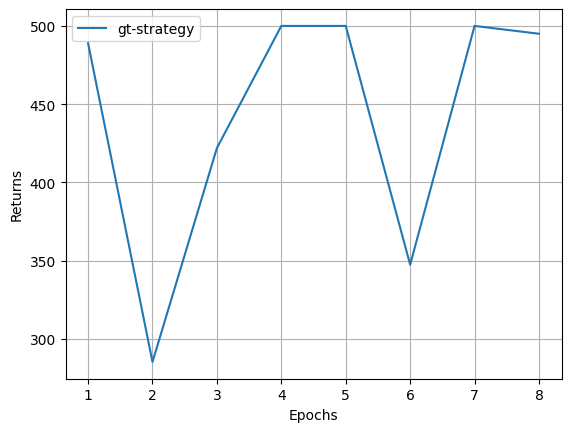

In [ ]:
plot_metrics(statistics, "gt-strategy")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

In [ ]:
import gym
from gym.wrappers import RecordVideo

# start virtual display
d3rlpy.notebook_utils.start_virtual_display()

# wrap RecordVideo wrapper
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), './video')

# evaluate
d3rlpy.metrics.evaluate_qlearning_with_environment(cql, env)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4
Moviepy - Building video /content/video/rl-video-episode-1.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1.mp4
Moviepy - Building video /content/video/rl-video-episode-8.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8.mp4


500.0

In [ ]:
d3rlpy.notebook_utils.render_video("video/rl-video-episode-0.mp4")

### Можно ли обучить на случайной стратегии?

#### Генерация случайной стратегии

In [ ]:
import d3rlpy

# setup algorithm
random_policy = d3rlpy.algos.DiscreteRandomPolicyConfig().create()

# prepare experience replay buffer
buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)

# start data collection
random_policy.collect(env, buffer, n_steps=100000)

# save ReplayBuffer
with open("random_policy_dataset.h5", "w+b") as f:
    buffer.dump(f)

2024-03-02 13:52.51 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-03-02 13:52.51 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-03-02 13:52.51 [info     ] Action size has been automatically determined. action_size=2
2024-03-02 13:52.51 [debug    ] Building model...             
2024-03-02 13:52.51 [debug    ] Model has been built.         


  0%|          | 0/100000 [00:00<?, ?it/s]

Moviepy - Building video /content/video/rl-video-episode-27.mp4.
Moviepy - Writing video /content/video/rl-video-episode-27.mp4




t:   0%|          | 0/25 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-27.mp4
Moviepy - Building video /content/video/rl-video-episode-64.mp4.
Moviepy - Writing video /content/video/rl-video-episode-64.mp4




t:   0%|          | 0/35 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-64.mp4
Moviepy - Building video /content/video/rl-video-episode-125.mp4.
Moviepy - Writing video /content/video/rl-video-episode-125.mp4




t:  92%|█████████▏| 44/48 [00:00<00:00, 436.63it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-125.mp4
Moviepy - Building video /content/video/rl-video-episode-216.mp4.
Moviepy - Writing video /content/video/rl-video-episode-216.mp4




t:   0%|          | 0/22 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-216.mp4
Moviepy - Building video /content/video/rl-video-episode-343.mp4.
Moviepy - Writing video /content/video/rl-video-episode-343.mp4




t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-343.mp4
Moviepy - Building video /content/video/rl-video-episode-512.mp4.
Moviepy - Writing video /content/video/rl-video-episode-512.mp4




t:   0%|          | 0/30 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-512.mp4
Moviepy - Building video /content/video/rl-video-episode-729.mp4.
Moviepy - Writing video /content/video/rl-video-episode-729.mp4




t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-729.mp4
Moviepy - Building video /content/video/rl-video-episode-1000.mp4.
Moviepy - Writing video /content/video/rl-video-episode-1000.mp4




t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-1000.mp4
Moviepy - Building video /content/video/rl-video-episode-2000.mp4.
Moviepy - Writing video /content/video/rl-video-episode-2000.mp4




t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-2000.mp4
Moviepy - Building video /content/video/rl-video-episode-3000.mp4.
Moviepy - Writing video /content/video/rl-video-episode-3000.mp4




t:   0%|          | 0/12 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-3000.mp4
Moviepy - Building video /content/video/rl-video-episode-4000.mp4.
Moviepy - Writing video /content/video/rl-video-episode-4000.mp4




t:  95%|█████████▍| 35/37 [00:00<00:00, 347.85it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-4000.mp4


In [ ]:
# setup CQL algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0')

# start training
statistics_random = cql.fit(
    buffer,
    n_steps=8000,
    n_steps_per_epoch=500,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env), # evaluate with CartPole-v1 environment
    },
)

2024-03-02 13:53.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[()]), reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2024-03-02 13:53.28 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240302135328
2024-03-02 13:53.28 [debug    ] Building models...            
2024-03-02 13:53.28 [debug    ] Models have been built.       
2024-03-02 13:53.28 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9,

Epoch 1/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.32 [info     ] DiscreteCQL_20240302135328: epoch=1 step=500 epoch=1 metrics={'time_sample_batch': 0.002244131565093994, 'time_algorithm_update': 0.005340512752532959, 'loss': 0.76086947453022, 'td_loss': 0.06742147336684866, 'conservative_loss': 0.6934480013847351, 'time_step': 0.007711957931518554, 'environment': 14.8} step=500
2024-03-02 13:53.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_500.d3


Epoch 2/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.35 [info     ] DiscreteCQL_20240302135328: epoch=2 step=1000 epoch=2 metrics={'time_sample_batch': 0.0018280725479125977, 'time_algorithm_update': 0.004751463413238525, 'loss': 0.6942827225923538, 'td_loss': 0.0008703683835046831, 'conservative_loss': 0.6934123542308808, 'time_step': 0.006658778190612793, 'environment': 9.2} step=1000
2024-03-02 13:53.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_1000.d3


Epoch 3/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.39 [info     ] DiscreteCQL_20240302135328: epoch=3 step=1500 epoch=3 metrics={'time_sample_batch': 0.0017804455757141112, 'time_algorithm_update': 0.004734493732452392, 'loss': 0.6943878779411315, 'td_loss': 0.000935935619432712, 'conservative_loss': 0.6934519419670105, 'time_step': 0.006583786010742188, 'environment': 11.8} step=1500
2024-03-02 13:53.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_1500.d3


Epoch 4/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.42 [info     ] DiscreteCQL_20240302135328: epoch=4 step=2000 epoch=4 metrics={'time_sample_batch': 0.0018790760040283204, 'time_algorithm_update': 0.004910336494445801, 'loss': 0.6941324127912522, 'td_loss': 0.0007855866301688366, 'conservative_loss': 0.6933468265533447, 'time_step': 0.006870750427246094, 'environment': 21.8} step=2000
2024-03-02 13:53.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_2000.d3


Epoch 5/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.46 [info     ] DiscreteCQL_20240302135328: epoch=5 step=2500 epoch=5 metrics={'time_sample_batch': 0.0020441694259643556, 'time_algorithm_update': 0.005192373752593994, 'loss': 0.6943786290884018, 'td_loss': 0.0008435699358815327, 'conservative_loss': 0.6935350600481033, 'time_step': 0.007335769176483154, 'environment': 9.3} step=2500
2024-03-02 13:53.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_2500.d3


Epoch 6/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.50 [info     ] DiscreteCQL_20240302135328: epoch=6 step=3000 epoch=6 metrics={'time_sample_batch': 0.0017940068244934081, 'time_algorithm_update': 0.004726281642913818, 'loss': 0.6941785389184951, 'td_loss': 0.0008529406693123747, 'conservative_loss': 0.6933255969285965, 'time_step': 0.00659305477142334, 'environment': 10.3} step=3000
2024-03-02 13:53.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_3000.d3


Epoch 7/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.53 [info     ] DiscreteCQL_20240302135328: epoch=7 step=3500 epoch=7 metrics={'time_sample_batch': 0.0018313961029052734, 'time_algorithm_update': 0.004904440879821777, 'loss': 0.6943629232645034, 'td_loss': 0.0008309650596638676, 'conservative_loss': 0.6935319588184357, 'time_step': 0.006812495708465576, 'environment': 9.9} step=3500
2024-03-02 13:53.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_3500.d3


Epoch 8/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:53.57 [info     ] DiscreteCQL_20240302135328: epoch=8 step=4000 epoch=8 metrics={'time_sample_batch': 0.00218452787399292, 'time_algorithm_update': 0.005445560932159424, 'loss': 0.6942734017372131, 'td_loss': 0.0007768750088725937, 'conservative_loss': 0.6934965265989304, 'time_step': 0.0077497057914733885, 'environment': 9.3} step=4000
2024-03-02 13:53.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_4000.d3


Epoch 9/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.01 [info     ] DiscreteCQL_20240302135328: epoch=9 step=4500 epoch=9 metrics={'time_sample_batch': 0.0018122611045837402, 'time_algorithm_update': 0.004778366088867187, 'loss': 0.6940988858938217, 'td_loss': 0.0007188029608514626, 'conservative_loss': 0.6933800826072692, 'time_step': 0.00666344404220581, 'environment': 11.9} step=4500
2024-03-02 13:54.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_4500.d3


Epoch 10/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.04 [info     ] DiscreteCQL_20240302135328: epoch=10 step=5000 epoch=10 metrics={'time_sample_batch': 0.0018836669921875, 'time_algorithm_update': 0.004791505813598633, 'loss': 0.6944479709863662, 'td_loss': 0.000777644375746604, 'conservative_loss': 0.6936703262329101, 'time_step': 0.006759036540985108, 'environment': 11.8} step=5000
2024-03-02 13:54.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_5000.d3


Epoch 11/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.09 [info     ] DiscreteCQL_20240302135328: epoch=11 step=5500 epoch=11 metrics={'time_sample_batch': 0.0024415664672851564, 'time_algorithm_update': 0.00716763162612915, 'loss': 0.6943782639503479, 'td_loss': 0.0007883588172262534, 'conservative_loss': 0.6935899044275284, 'time_step': 0.009745225429534913, 'environment': 9.8} step=5500
2024-03-02 13:54.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_5500.d3


Epoch 12/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.13 [info     ] DiscreteCQL_20240302135328: epoch=12 step=6000 epoch=12 metrics={'time_sample_batch': 0.001989694595336914, 'time_algorithm_update': 0.00509815502166748, 'loss': 0.6942604702711105, 'td_loss': 0.0007231611597817391, 'conservative_loss': 0.6935373089313507, 'time_step': 0.00717313814163208, 'environment': 9.3} step=6000
2024-03-02 13:54.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_6000.d3


Epoch 13/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.18 [info     ] DiscreteCQL_20240302135328: epoch=13 step=6500 epoch=13 metrics={'time_sample_batch': 0.002724132537841797, 'time_algorithm_update': 0.006499371528625488, 'loss': 0.6942484363317489, 'td_loss': 0.0006992257574747783, 'conservative_loss': 0.6935492099523545, 'time_step': 0.009404126167297364, 'environment': 12.0} step=6500
2024-03-02 13:54.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_6500.d3


Epoch 14/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.22 [info     ] DiscreteCQL_20240302135328: epoch=14 step=7000 epoch=14 metrics={'time_sample_batch': 0.002164651393890381, 'time_algorithm_update': 0.005416038036346435, 'loss': 0.6939963661432266, 'td_loss': 0.0006449332035990665, 'conservative_loss': 0.6933514324426651, 'time_step': 0.00770582914352417, 'environment': 9.3} step=7000
2024-03-02 13:54.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_7000.d3


Epoch 15/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.25 [info     ] DiscreteCQL_20240302135328: epoch=15 step=7500 epoch=15 metrics={'time_sample_batch': 0.001876305103302002, 'time_algorithm_update': 0.00495605182647705, 'loss': 0.6937939697504043, 'td_loss': 0.0006638571862131357, 'conservative_loss': 0.6931301124095917, 'time_step': 0.0069117631912231445, 'environment': 9.6} step=7500
2024-03-02 13:54.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_7500.d3


Epoch 16/16:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:54.29 [info     ] DiscreteCQL_20240302135328: epoch=16 step=8000 epoch=16 metrics={'time_sample_batch': 0.0019128198623657227, 'time_algorithm_update': 0.004931804180145264, 'loss': 0.6943003913164139, 'td_loss': 0.0008012329604534898, 'conservative_loss': 0.6934991574287415, 'time_step': 0.00692477560043335, 'environment': 11.6} step=8000
2024-03-02 13:54.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135328/model_8000.d3


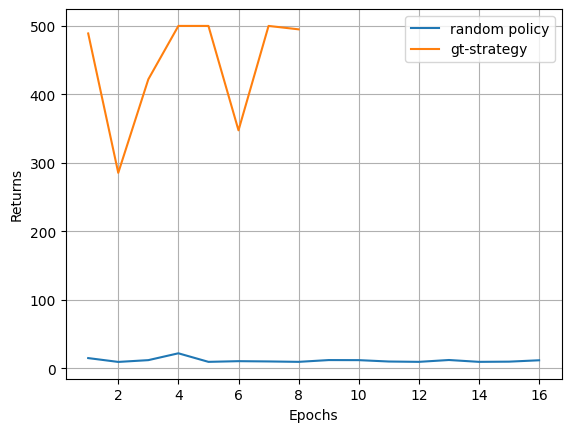

In [ ]:
plot_metrics(statistics_random, "random policy")
plot_metrics(statistics, "gt-strategy")
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

### Как будет менятся обучение агента на смешанной стратегии (часть данных экспертные - чать случайные)?

In [ ]:
def dataset_with_terminals(buffer, size):
  observations = []
  actions = []
  rewards = []
  terminals = []

  for episode in buffer.episodes[:size]:
    observations+=episode.observations.tolist()
    actions += episode.actions.tolist()
    rewards += episode.rewards.tolist()

    terminal = [0 for _ in range(len(episode.rewards))]
    terminal[-1] = 1
    terminals += terminal
  return observations, actions, rewards, terminals


In [ ]:
import numpy as np
observations, actions, rewards, terminals = dataset_with_terminals(dataset, 2000)
rnd_observations, rnd_actions, rnd_rewards, rnd_terminals = dataset_with_terminals(buffer, 2000)

mxt_obs = np.asarray(observations+rnd_observations)
mxt_actions = np.asarray(actions+rnd_actions)
mxt_rewards = np.asarray(rewards+rnd_rewards)
mxt_terminals = np.asarray(terminals+rnd_terminals).reshape(-1,1)

In [ ]:
import numpy as np

mixed_dataset = d3rlpy.dataset.MDPDataset(
    observations=mxt_obs,
    actions=mxt_actions,
    rewards=mxt_rewards,
    terminals=mxt_terminals,
)

2024-03-02 13:55.49 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(4,)]) reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)])
2024-03-02 13:55.49 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-03-02 13:55.49 [info     ] Action size has been automatically determined. action_size=2


In [ ]:

# setup CQL algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0')

# start training
statistics_on_mixed = cql.fit(
    mixed_dataset,
    n_steps=4000,
    n_steps_per_epoch=500,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env), # evaluate with CartPole-v1 environment
    },
)

2024-03-02 13:56.00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2024-03-02 13:56.00 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20240302135600
2024-03-02 13:56.00 [debug    ] Building models...            
2024-03-02 13:56.00 [debug    ] Models have been built.       
2024-03-02 13:56.00 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': [0

Epoch 1/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.06 [info     ] DiscreteCQL_20240302135600: epoch=1 step=500 epoch=1 metrics={'time_sample_batch': 0.001622401714324951, 'time_algorithm_update': 0.004916701316833496, 'loss': 0.7492333461046219, 'td_loss': 0.06303286619950085, 'conservative_loss': 0.6862004799842835, 'time_step': 0.006636744976043702, 'environment': 424.4} step=500
2024-03-02 13:56.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_500.d3


Epoch 2/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.11 [info     ] DiscreteCQL_20240302135600: epoch=2 step=1000 epoch=2 metrics={'time_sample_batch': 0.001445502758026123, 'time_algorithm_update': 0.004673801422119141, 'loss': 0.6839548047780991, 'td_loss': 0.003801441097166389, 'conservative_loss': 0.6801533634662629, 'time_step': 0.006186518669128418, 'environment': 487.2} step=1000
2024-03-02 13:56.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_1000.d3


Epoch 3/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.17 [info     ] DiscreteCQL_20240302135600: epoch=3 step=1500 epoch=3 metrics={'time_sample_batch': 0.0014500727653503419, 'time_algorithm_update': 0.004739633560180664, 'loss': 0.6844648202657699, 'td_loss': 0.003746253411285579, 'conservative_loss': 0.6807185665369034, 'time_step': 0.006258292198181152, 'environment': 453.0} step=1500
2024-03-02 13:56.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_1500.d3


Epoch 4/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.23 [info     ] DiscreteCQL_20240302135600: epoch=4 step=2000 epoch=4 metrics={'time_sample_batch': 0.0014729337692260742, 'time_algorithm_update': 0.004800953388214111, 'loss': 0.6839748694896698, 'td_loss': 0.0037292917561717333, 'conservative_loss': 0.6802455780506134, 'time_step': 0.006347734451293946, 'environment': 476.6} step=2000
2024-03-02 13:56.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_2000.d3


Epoch 5/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.29 [info     ] DiscreteCQL_20240302135600: epoch=5 step=2500 epoch=5 metrics={'time_sample_batch': 0.0014681453704833984, 'time_algorithm_update': 0.004772698402404785, 'loss': 0.6834479095935821, 'td_loss': 0.004376337370369583, 'conservative_loss': 0.6790715734958649, 'time_step': 0.006316247940063476, 'environment': 365.2} step=2500
2024-03-02 13:56.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_2500.d3


Epoch 6/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.33 [info     ] DiscreteCQL_20240302135600: epoch=6 step=3000 epoch=6 metrics={'time_sample_batch': 0.0014632668495178224, 'time_algorithm_update': 0.004644636154174805, 'loss': 0.6820755362510681, 'td_loss': 0.004691913110436871, 'conservative_loss': 0.6773836214542389, 'time_step': 0.006177744388580322, 'environment': 343.3} step=3000
2024-03-02 13:56.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_3000.d3


Epoch 7/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.37 [info     ] DiscreteCQL_20240302135600: epoch=7 step=3500 epoch=7 metrics={'time_sample_batch': 0.0014376640319824219, 'time_algorithm_update': 0.004709536552429199, 'loss': 0.6809495397806168, 'td_loss': 0.00474243553634733, 'conservative_loss': 0.6762071051597596, 'time_step': 0.006216299533843994, 'environment': 45.3} step=3500
2024-03-02 13:56.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_3500.d3


Epoch 8/8:   0%|          | 0/500 [00:00<?, ?it/s]

2024-03-02 13:56.43 [info     ] DiscreteCQL_20240302135600: epoch=8 step=4000 epoch=8 metrics={'time_sample_batch': 0.0017413129806518554, 'time_algorithm_update': 0.005376931667327881, 'loss': 0.6826761800050736, 'td_loss': 0.004820076102158055, 'conservative_loss': 0.6778561016321182, 'time_step': 0.00723330020904541, 'environment': 459.4} step=4000
2024-03-02 13:56.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20240302135600/model_4000.d3


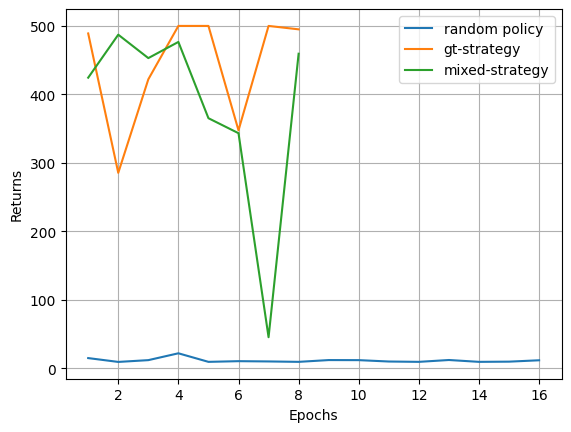

In [ ]:
plot_metrics(statistics_random, "random policy")
plot_metrics(statistics, "gt-strategy")
plot_metrics(statistics_on_mixed, "mixed-strategy")

plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()

### Эксперементируем качесвом датасета

In [ ]:
import structlog

# Процессор, который отбрасывает все логи
def drop_all_logs(logger, log_method, event_dict):
    raise structlog.DropEvent

# Настройка structlog
structlog.configure(
    processors=[
        drop_all_logs,
    ],
)

In [ ]:
def make_mixed_dataset(dataset_1, dataset_2, proportions = [1,1]):

  """ YOUR CODE HERE """
  # Реализовать логику получения смешанного датасета в указанных пропорциях
  # 1 - отобрать эпизоды из каждого датасета в нужной пропорции
  # 2 - получать массивы данных с terminals через dataset_with_terminals
  # 3 - получаить смешанный массив данных через  MDPDataset

  """ YOUR CODE HERE """

  return mixed_dataset


In [ ]:
proportions = (0.5, 0.5), (0.1, 0.9), (0.9, 0.1)
datasets = []
for p in proportions:
  datasets.append(make_mixed_dataset(dataset, buffer, p))


In [ ]:
import tqdm

statistics = {p:[] for p in proportions}

for i in range(5):
  for j,d in tqdm.tqdm(enumerate(datasets)):

    # setup CQL algorithm
    cql = d3rlpy.algos.DiscreteCQLConfig().create(device='cuda:0')

    # start training
    s = cql.fit(
        d,
        n_steps=10000,
        n_steps_per_epoch=1000,
        evaluators={
            'environment': d3rlpy.metrics.EnvironmentEvaluator(env), # evaluate with CartPole-v1 environment
        },
        show_progress=False
    );
    statistics[proportions[j]].append(s)


1it [01:53, 74.90s/it]

Moviepy - Building video /content/video/rl-video-episode-8000.mp4.
Moviepy - Writing video /content/video/rl-video-episode-8000.mp4




t:  94%|█████████▎| 164/175 [00:00<00:00, 332.99it/s, now=None]
1it [01:53, 74.90s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-8000.mp4


3it [03:37, 72.42s/it]
3it [03:30, 70.33s/it]
3it [03:34, 71.46s/it]
2it [03:02, 67.64s/it]

Moviepy - Building video /content/video/rl-video-episode-9000.mp4.
Moviepy - Writing video /content/video/rl-video-episode-9000.mp4




t:  97%|█████████▋| 259/267 [00:00<00:00, 328.35it/s, now=None]
2it [03:03, 67.64s/it]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-9000.mp4


3it [03:33, 71.07s/it]
3it [03:26, 68.81s/it]


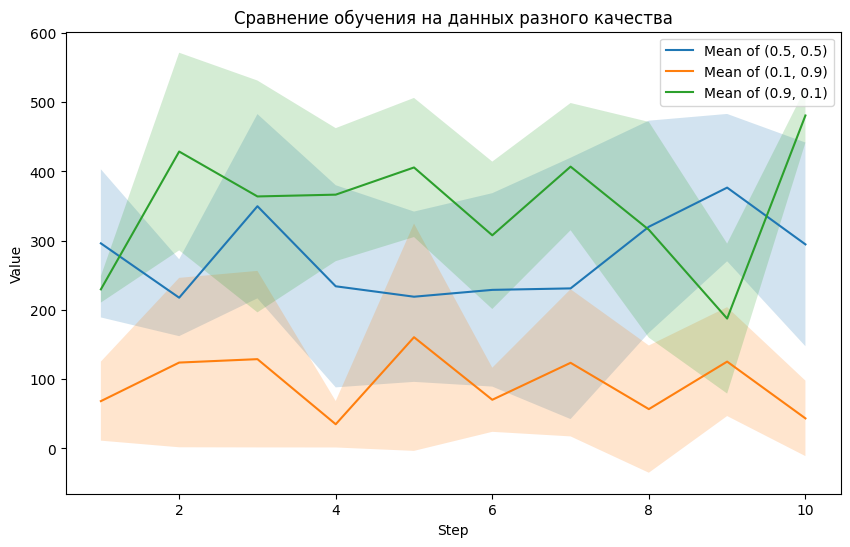

In [ ]:
visualize_with_std(statistics, proportions)

plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Реализовать обучение на других алгаритмах, к примеру  DiscreteBCConfig



  """ YOUR CODE HERE """
  # Подсказка: все как в прошлом коде, только необходимо заменить алгоритм

  """ YOUR CODE HERE """

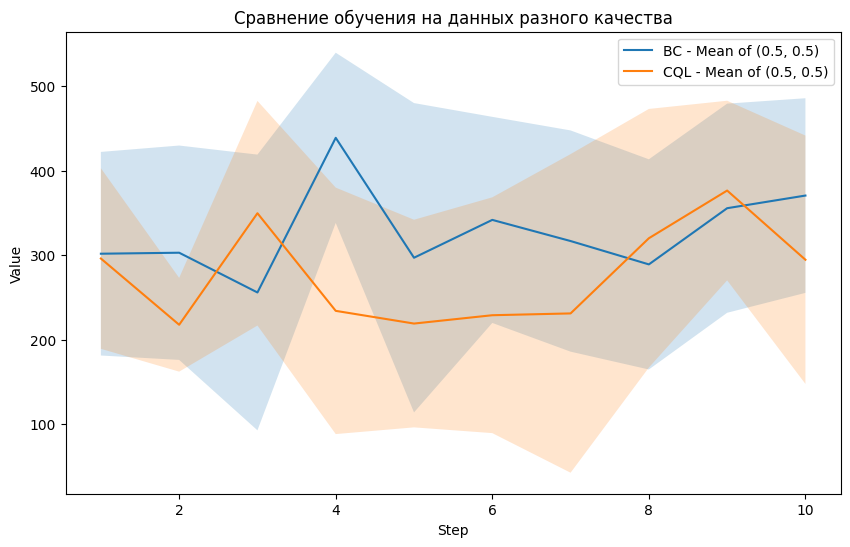

In [ ]:

plt.figure(figsize=(10, 6))

visualize_with_std(statistics_bc, proportions = [(0.5, 0.5)], label="BC")
visualize_with_std(statistics, proportions = [(0.5, 0.5)], label="CQL")

plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Реализовать обучение для другой среды, к примеру pendulum

In [ ]:
help(d3rlpy.datasets)

Help on module d3rlpy.datasets in d3rlpy:

NAME
    d3rlpy.datasets - # pylint: disable=unused-import,too-many-return-statements

FUNCTIONS
    get_atari(env_name: str, num_stack: Optional[int] = None, sticky_action: bool = True, pre_stack: bool = False, render_mode: Optional[str] = None) -> Tuple[d3rlpy.dataset.replay_buffer.ReplayBuffer, gym.core.Env[numpy.ndarray[Any, numpy.dtype[Any]], int]]
        Returns atari dataset and envrironment.
        
        The dataset is provided through d4rl-atari. See more details including
        available dataset from its GitHub page.
        
        .. code-block:: python
        
            from d3rlpy.datasets import get_atari
        
            dataset, env = get_atari('breakout-mixed-v0')
        
        References:
            * https://github.com/takuseno/d4rl-atari
        
        Args:
            env_name: environment id of d4rl-atari dataset.
            num_stack: the number of frames to stack (only applied to env).
          

### Пример с pendulum

In [ ]:
import d3rlpy

# get CartPole dataset
dataset, env = d3rlpy.datasets.get_pendulum()

In [ ]:
# setup algorithm
random_policy = d3rlpy.algos.RandomPolicyConfig().create()

# prepare experience replay buffer
buffer = d3rlpy.dataset.create_fifo_replay_buffer(limit=100000, env=env)

# start data collection
random_policy.collect(env, buffer, n_steps=100000)

In [ ]:
cql = d3rlpy.algos.CQLConfig().create(device='cuda:0')

    # start training
s = cql.fit(
    dataset,
    n_steps=10000,
    n_steps_per_epoch=1000,
    evaluators={
        'environment': d3rlpy.metrics.EnvironmentEvaluator(env), # evaluate with CartPole-v1 environment
    },
    show_progress=False
);


In [ ]:
plot_metrics(s, "on expert")

plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.legend()
plt.grid()